### 1. Installing dependencies

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### 2. Getting the data from directory

In [20]:
file_path = "/content/drive/MyDrive/Alzheimer-Disease-Prediction/Dataset"
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']


### 3. Visualizing random images with labels from the data

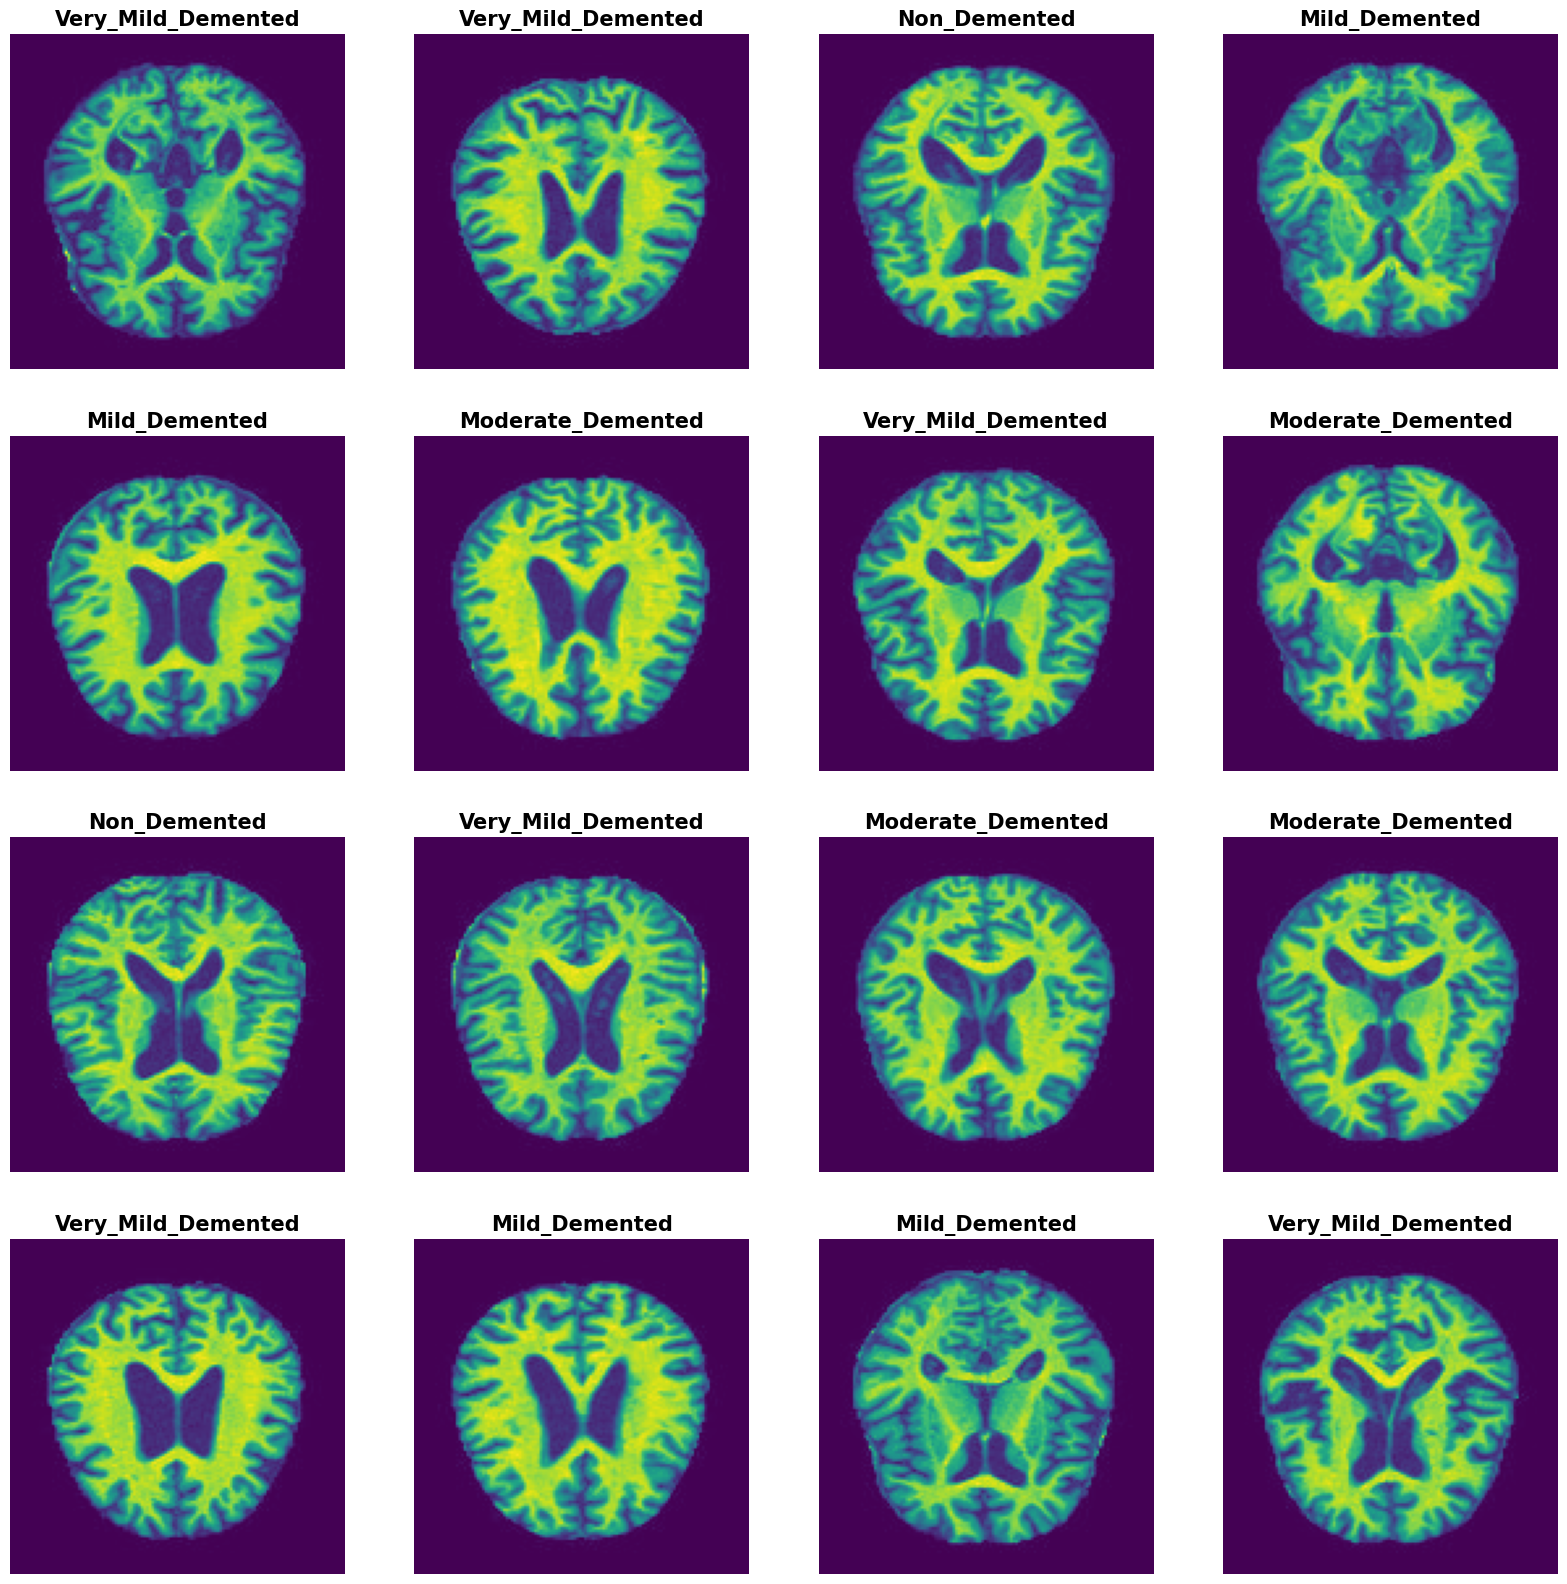

In [21]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    random_class = random.randint(0, 3)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = plt.imread(random_image_path)
    plt.axis('off')
    plt.title(class_names[random_class], fontsize = 15, fontweight = 'bold')
    plt.imshow(image)

### 4. Preparing the dataset for building CNN

In [22]:
SEED = 1   # maybe can do with random seed generator and compare results with different seed values in the future.
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

X_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'training'
)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'validation'
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


### 5. Building the model

In [23]:
INPUT_SHAPE = IMG_SIZE + (3,)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./255, input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,121,380 (8.09 MB)

 Trainable params: 2,121,380 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

### 6. Fitting the model

In [24]:
history = model.fit(X_train, epochs = 50, validation_data=X_validation, verbose=1)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1021s 6s/step - accuracy: 0.4968 - loss: 1.0311 - val_accuracy: 0.5562 - val_loss: 0.9107
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 686ms/step - accuracy: 0.6182 - loss: 0.8487 - val_accuracy: 0.6797 - val_loss: 0.7244
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 688ms/step - accuracy: 0.7344 - loss: 0.6276 - val_accuracy: 0.7922 - val_loss: 0.4766
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 694ms/step - accuracy: 0.8301 - loss: 0.4145 - val_accuracy: 0.8250 - val_loss: 0.3887
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 703ms/step - accuracy: 0.9063 - loss: 0.2461 - val_accuracy: 0.9273 - val_loss: 0.2103
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 692ms/step - accuracy: 0.9350 - loss: 0.1742 - val_accuracy: 0.9375 - val_loss: 0.1938
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 685ms/step - accuracy: 0.9642 - loss: 0.1097 - val_accuracy: 0.8789 - val_loss: 0.3536
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 686ms/step - accuracy: 0.9555 - l

### 7. Model evaluation

In [25]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.9817 - loss: 0.0751
Accuracy: % 97.81
Loss: % 8.36


[]

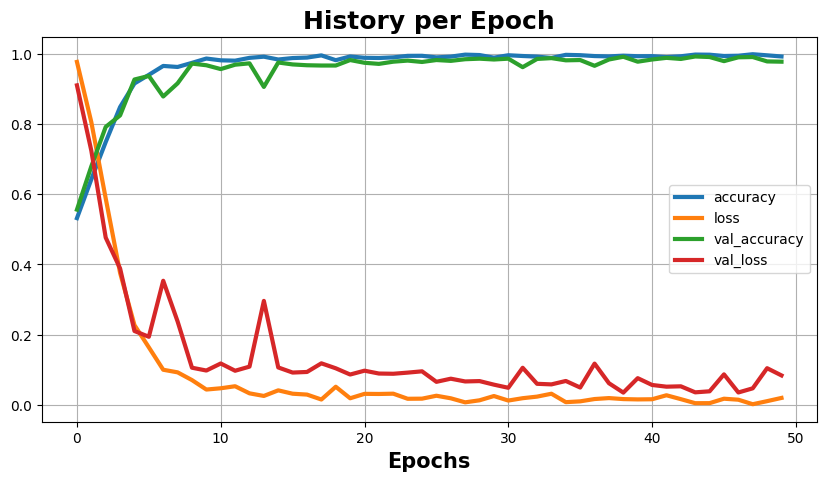

In [26]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


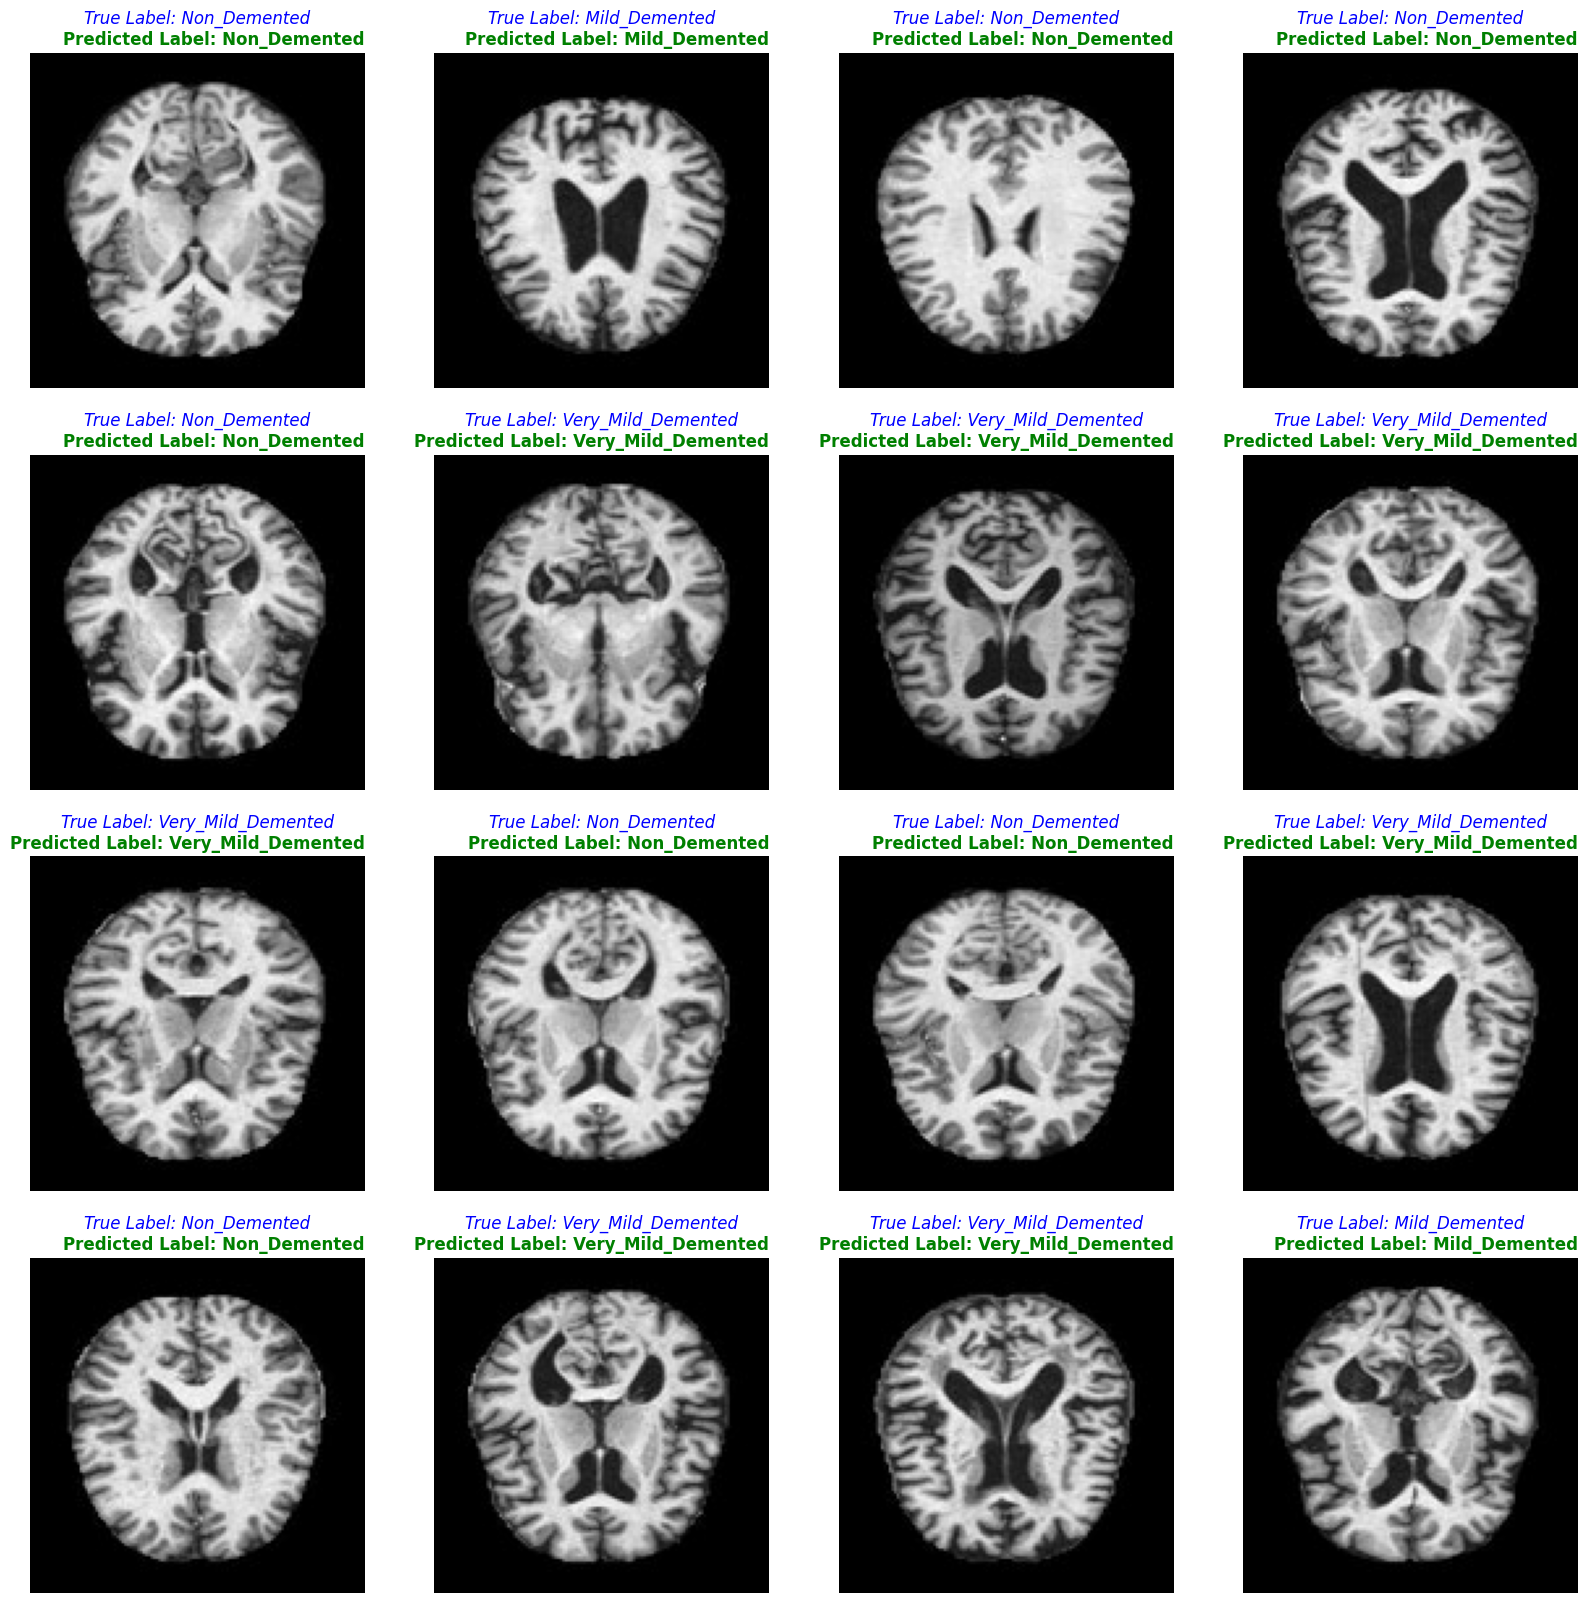

In [27]:
plt.figure(figsize=(20, 20))
for image, label in X_validation.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))
        plt.axis('off')
        plt.title("True Label: " + class_names[label[i]]+'\n', fontsize=12, style='italic', color='blue', loc='center')
        plt.title("Predicted Label: " + class_names[predicted_class], fontsize=12, fontweight='bold', color='green', loc='right')
        plt.imshow(image[i].numpy().astype("uint8"))